In [1]:
import sys
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
sys.path.append(".")
# os.environ["MAX_JOBS"] = "100"

import torch
torch.set_printoptions(linewidth=200, threshold=100000)
torch.cuda.is_available()

from tqdm import tqdm
import matplotlib.pyplot as plt
from plot_utils import plot_numerical_diffs, plot_numerical_diffs_single

In [2]:
from src.vlstm_fwbw_v2.interface import vlstm_fwbw_torch_autogradbw
from src.vlstm_fwbw_v2.interface import vlstm_fw_torch, vlstm_fw_cuda
from src.vlstm_fwbw_v2.interface import vlstm_bw_torch_obw, vlstm_bw_cuda

INCLUDE: ['/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/torch/csrc/api/include', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/TH', '/home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/THC', '/home/max/miniconda3/envs/xlstmpt220cu121/include']
/home/max/myrepos/vlstm_cuda/src
/home/max/cpplibs/libtorch/lib:/usr/local/cuda-12.3/lib64:
/home/max/miniconda3/envs/xlstmpt220cu121/lib


Using /home/max/.cache/torch_extensions/py311_cu121 as PyTorch extensions root...
Detected CUDA files, patching ldflags
Emitting ninja build file /home/max/.cache/torch_extensions/py311_cu121/vlstm_fwbw_v2/build.ninja...
Building extension module vlstm_fwbw_v2...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/2] /home/max/miniconda3/envs/xlstmpt220cu121/bin/nvcc --generate-dependencies-with-compile --dependency-output kernel_fw.cuda.o.d -ccbin /home/max/miniconda3/envs/xlstmpt220cu121/bin/x86_64-conda-linux-gnu-cc -DTORCH_EXTENSION_NAME=vlstm_fwbw_v2 -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1011\" -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/torch/csrc/api/include -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/TH -isystem /home/max/miniconda3/envs/xlstmpt220cu121/lib/python3.11/site-packages/torch/include/THC -isystem /home/max/miniconda3/envs/xlstmpt220cu121/include -isystem /home/max/miniconda3/envs/xlstmpt220cu121/include/python3.11 -D_GLIBCXX_USE_CXX11_ABI=0 -D__CUDA_NO_HALF_OPERATORS__ -D__CUDA_NO_HALF_CONVERS

Loading extension module vlstm_fwbw_v2...


In [3]:
# non tensor core version:
# ptxas info    : 136 bytes gmem
# ptxas info    : Compiling entry function '_ZN5vlstm7kernels8vlstm_fwI6__halfLi64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii' for 'sm_89'
# ptxas info    : Function properties for _ZN5vlstm7kernels8vlstm_fwI6__halfLi64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii
#     24 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
# ptxas info    : Used 77 registers, 448 bytes cmem[0]
# ptxas info    : Compiling entry function '_ZN5vlstm7kernels8vlstm_fwI13__nv_bfloat16Li64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii' for 'sm_89'
# ptxas info    : Function properties for _ZN5vlstm7kernels8vlstm_fwI13__nv_bfloat16Li64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii
#     24 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
# ptxas info    : Used 77 registers, 448 bytes cmem[0]

# tensor core version:
# ptxas info    : 136 bytes gmem
# ptxas info    : Compiling entry function '_ZN5vlstm7kernels8vlstm_fwI6__halfLi64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii' for 'sm_89'
# ptxas info    : Function properties for _ZN5vlstm7kernels8vlstm_fwI6__halfLi64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii
#     24 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
# ptxas info    : Used 96 registers, 448 bytes cmem[0]
# ptxas info    : Compiling entry function '_ZN5vlstm7kernels8vlstm_fwI13__nv_bfloat16Li64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii' for 'sm_89'
# ptxas info    : Function properties for _ZN5vlstm7kernels8vlstm_fwI13__nv_bfloat16Li64ELi64EEEvPT_S4_S4_S4_S4_S4_S4_S4_S4_Pfiiii
#     24 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
# ptxas info    : Used 94 registers, 448 bytes cmem[0]

## CUDA vLSTM forward-backward 

Choose large tile sizes.

### Get gpu_info

In [4]:
from src.gpu_info.gpu_info import get_gpu_info

In [5]:
# get_gpu_info(0)

### define inputs

In [6]:
S = 128 #32 #32 #16 #8 # seq len
B = 1 # batch size
NH = 1 # num heads
DH = 96 # dim per head
DTYPE = torch.float32
DEVICE = torch.device("cuda:0")

In [7]:
# create qkv, inputgates, forgetgates 
torch.manual_seed(1) #TODO from here: with seed=0 even the pytorch version alone breaks for float16 and bfloat16
# fixed:
# qs = torch.arange((B*NH*S*DH), device=DEVICE, dtype=DTYPE).reshape((B, NH, S, DH)) / 10.
# qs = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# ks = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# # vs = torch.ones((B, NH, S, DH), device=DEVICE, dtype=DTYPE) / 100.
# vs = torch.arange((B*NH*S*DH), device=DEVICE, dtype=DTYPE).reshape((B, NH, S, DH)) / 100.
# # vs = torch.zeros((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
# vs[:,:,1,0] = 7.
# qs[:,:,1,0] = 1.

# vs[:,:,1,16] = 8.
# qs[:,:,1,16] = 1.
# random: 
qs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
ks = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
vs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)
# igs = (1. + torch.arange((B * NH * S), device=DEVICE, dtype=DTYPE)).reshape(B, NH, S, 1) / 10.
# igs = torch.zeros((B, NH, S, 1), device=DEVICE, dtype=DTYPE) #/ 10.
igs = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE) #/ 10.
# fgs = torch.ones((B, NH, S, 1), device=DEVICE, dtype=DTYPE)
fgs = torch.randn((B, NH, S, 1), device=DEVICE, dtype=DTYPE)

dHs = torch.randn((B, NH, S, DH), device=DEVICE, dtype=DTYPE)

In [8]:
# qs[:, :, 16,0] = 1.

In [9]:
# inputs float16
dtype_fp16 = torch.float16
qs_half = qs.to(dtype=dtype_fp16)
ks_half = ks.to(dtype=dtype_fp16)
vs_half = vs.to(dtype=dtype_fp16)
igs_half = igs.to(dtype=dtype_fp16)
fgs_half = fgs.to(dtype=dtype_fp16)
dHs_half = dHs.to(dtype=dtype_fp16)

In [10]:
# inputs bfloat16
dtype_bf16 = torch.bfloat16
qs_bf16 = qs.to(dtype=dtype_bf16)
ks_bf16 = ks.to(dtype=dtype_bf16)
vs_bf16 = vs.to(dtype=dtype_bf16)
igs_bf16 = igs.to(dtype=dtype_bf16)
fgs_bf16 = fgs.to(dtype=dtype_bf16)
dHs_bf16 = dHs.to(dtype=dtype_bf16)

### compare errors pure pytorch

In [11]:
hs_pt, n_pt, m_pt, _, matLogD_pt, matD_pt, matC_pt = vlstm_fw_torch(queries=qs, keys=ks, values=vs, igate_preact=igs, fgate_preact=fgs)

In [12]:
hs_pt_half, n_pt_half, m_pt_half, _, matLogD_pt_half, matD_pt_half, matC_pt_half = vlstm_fw_torch(queries=qs_half, keys=ks_half, values=vs_half, igate_preact=igs_half, fgate_preact=fgs_half)

In [13]:
hs_pt_bf16, n_pt_bf16, m_pt_bf16, _, matLogD_pt_bf16, matD_pt_bf16, matC_pt_bf16 = vlstm_fw_torch(queries=qs_bf16, keys=ks_bf16, values=vs_bf16, igate_preact=igs_bf16, fgate_preact=fgs_bf16)

In [14]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"====== Full -> Half ======")
print(f"fw hs match: {torch.allclose(hs_pt_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_pt_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_pt_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_pt_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_pt_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_pt_half.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_pt_half.float() - matD_pt).tril())}")

print(f"====== Full -> bfloat16 ======")
print(f"fw hs match: {torch.allclose(hs_pt_bf16.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_pt_bf16 - hs_pt))}")
print(f"fw n match: {torch.allclose(n_pt_bf16.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_pt_bf16 - n_pt))}")
print(f"fw m match: {torch.allclose(m_pt_bf16.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_pt_bf16 - m_pt))}")
print(f"fw D match: {torch.allclose((matD_pt_bf16.float() - matD_pt).tril(), torch.zeros_like((matD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_pt_bf16.float() - matD_pt).tril())}")


====== Full -> Half ======
fw hs match: False, max diff: 0.4127330780029297
fw n match: False, max diff: 0.07650995254516602
fw m match: False, max diff: 0.0532890260219574
fw D match: False, max diff: 0.02229440212249756
====== Full -> bfloat16 ======
fw hs match: False, max diff: 19.54820442199707
fw n match: False, max diff: 1.322603702545166
fw m match: False, max diff: 0.42647314071655273
fw D match: False, max diff: 0.24758583307266235


### match directly

In [15]:
# cuda kernel float32
# hs_cu, n_cu, m_cu, matD_cu = vlstm_fw_cuda(mat_Q=qs, mat_K=ks, mat_V=vs, vec_igp=igs, vec_fgp=fgs)

In [16]:
hs_cu = hs_pt
n_cu = n_pt
m_cu = m_pt
matD_cu = matD_pt

In [17]:
s_pt_half = (qs_half @ ks_half.transpose(-2, -1)).tril()
s_pt_half.shape

torch.Size([1, 1, 128, 128])

In [18]:
def lower_triangular_block_matrix(n, block_size):
    assert n % block_size == 0
    n_blocks = n // block_size
    
    mat = torch.zeros((n, n), device=DEVICE, dtype=DTYPE)
    for i in range(n_blocks):
        mat[i*block_size:(i+1)*block_size, :(i+1)*block_size] = 1.
    return mat

In [19]:
# compute the baseline for qkv tensor core computation
ltr_bmat = lower_triangular_block_matrix(S, 16)
s_block_pt = (qs @ ks.transpose(-2, -1)) * ltr_bmat
qkv_block_pt = s_block_pt @ vs

In [ ]:
# cuda kernel float16
hs_cu_half, n_cu_half, m_cu_half, matD_cu_half = vlstm_fw_cuda(mat_Q=qs_half, mat_K=ks_half, mat_V=vs_half, vec_igp=igs_half, vec_fgp=fgs_half)

tensor(390.4068, device='cuda:0')

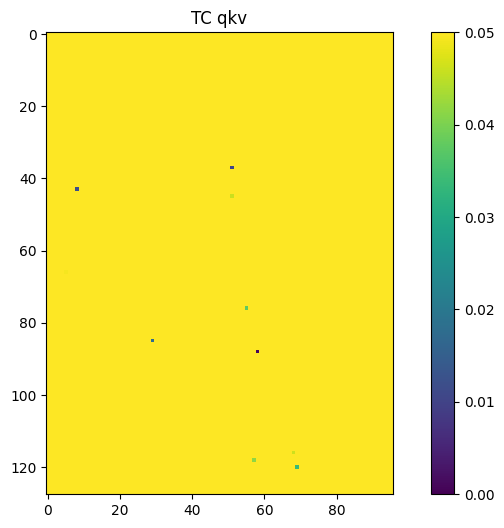

In [ ]:
fig = plot_numerical_diffs_single(hs_cu_half, qkv_block_pt, title="TC qkv", vmax=0.05)
(hs_cu_half - qkv_block_pt).abs().max()

In [ ]:
t1 = torch.tensor([8.3190], dtype=torch.float32, device=DEVICE)
print(t1)
print(t1.half())

tensor([8.3190], device='cuda:0')
tensor([8.3203], device='cuda:0', dtype=torch.float16)


In [ ]:
qkv_block_pt[:, :, -10:, :15]

tensor([[[[  -8.9331,  226.2968,   99.5339,  172.1936,  -19.1723,  -92.4837,  196.1176, -137.8358,   -7.4742,   87.8322,  -39.8324,   47.0205,  274.7249,  173.5845, -124.8089],
          [  81.0657, -151.5468,  125.8585,  -14.0208,   24.5110,   64.6904,  187.0397,    7.9207,   -2.1187,  229.9091, -210.2964,  -21.3674,  -26.4823,   22.7863,   95.8640],
          [ 165.1210,   32.9703,  112.0313,  -60.3774, -123.2558,  -16.4222,   -8.2115,  128.7446,    3.6360,   17.3155,  -20.8665,   79.4660, -156.3195, -109.4273,  -93.5056],
          [  46.5411,  190.4178,   18.9953,  121.6045,  191.4797,   95.3280,  -35.9550, -152.4927,  -76.5321,  -30.5914,  149.2084,   47.5513,  132.6076,  -45.5365,  -57.1667],
          [  31.2823,  -39.9522, -103.7935,  200.9965,   -5.2698, -110.0885, -153.9229,   16.7765,   14.9660, -113.9798,   89.7910,  121.1193,  135.5185,  101.5350,  209.2152],
          [ -68.6763, -176.8845,  -77.8899,    6.5153,  122.3696,   -8.3924,   27.5253,   48.5586,    1.9959,  -71.

In [ ]:
hs_cu_half[:, :, -10:, :15]

tensor([[[[  2.7871,   6.7500,   4.7148,  -6.2500,   2.8926,  -5.1211, -12.3047,  13.4297,   7.0586, -17.6562,   7.5664,  -3.2461,  12.1875,  -2.1621, -11.2891],
          [ -2.0371, -41.7188,  -1.2705,  14.8594,  15.9453,   1.7041,  -4.5234,  35.8125,  -8.9453,  -8.2578,  -5.7734,   0.3076,   4.1836, -23.7969, -12.9453],
          [ -5.8516,  -4.6016,   0.8989,  -2.9375,   3.9766,   4.2578,   2.0762,  -4.7148,  -0.2686,  10.2422, -11.3516,   1.1807,  -7.2422,  -1.0957,   2.5449],
          [ -6.0156, -10.3125,   7.3320,  -8.2812,  18.5156,  -7.5469,  11.1641,   1.3867, -19.4844, -14.7812,  21.9844,  -3.0234,  18.0938,  -9.1016,  -0.4387],
          [ 14.9453,   7.8203,   3.5664,  11.0000, -13.8516, -13.1406, -15.1875,  28.8594,   9.2422, -23.7656,  24.4688,  -2.6367,  21.9531,   4.0430, -15.9688],
          [ -0.9087,  16.2812, -11.7344,   1.5127,   5.6211,  -3.9531,   3.0137,   5.9375,   0.5356, -21.1250,   3.8281,  12.1406,  13.9141, -16.4375,  14.5625],
          [ 10.1250,  15.703

tensor(390.4068, device='cuda:0')

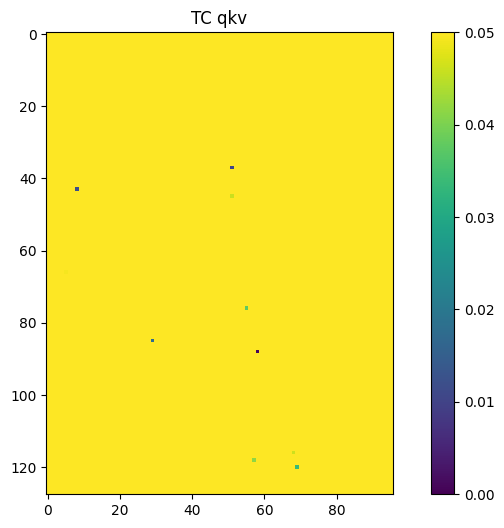

In [ ]:
fig = plot_numerical_diffs_single(hs_cu_half, qkv_block_pt, title="TC qkv", vmax=0.05)
(hs_cu_half - qkv_block_pt).abs().max()

In [ ]:
s_pt_half[:, :, :16, :12]

tensor([[[[  9.9297,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [ 13.2578,   6.8711,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [ -7.4570,   7.9727,   7.3398,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [ -1.7695,  -0.8560,   7.5391, -16.5312,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [ -3.5684,  -7.4180,  -4.7344,  10.8594,  11.2266,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [ -2.1602,  17.6250,   8.1250, -10.1875,  -5.4180,  -4.2812,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [  2.7363,   2.5859,  -1.9131, -10.7344,  -0.1101,  -0.8018,  -1.9932,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
          [ 23.3594,  -9.7891,   4.2969, -16.5625,  -3.8125,  -8.0938,   2.2

In [ ]:
matD_cu_half[:, :, :16, 0:12]

tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]], device='cuda:0', dtype=torch.float16)

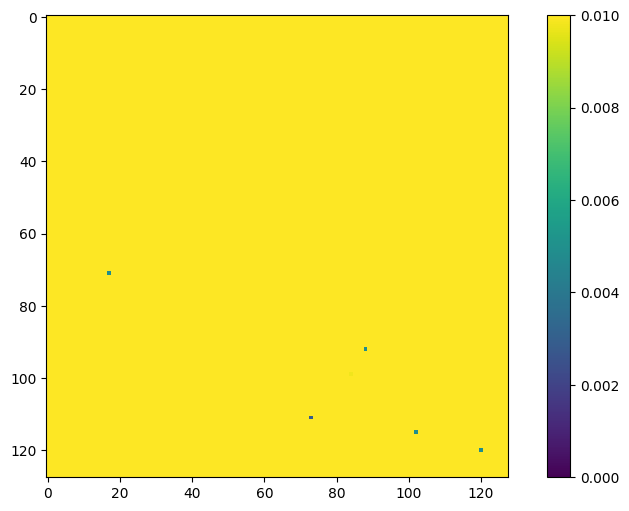

In [ ]:
fig = plot_numerical_diffs_single(s_pt_half, matD_cu_half)

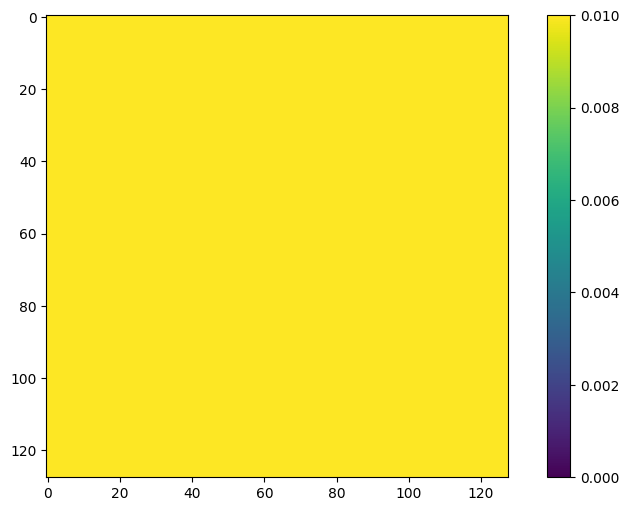

In [ ]:
fig = plot_numerical_diffs_single(matD_cu_half)

In [ ]:
matLogD_pt[:, :, -10:, :10]

tensor([[[[ -98.2648,  -98.3531,  -96.2879,  -95.3749,  -95.5976,  -94.9109,  -92.5303,  -91.5547,  -92.1308,  -89.1521],
          [ -99.5233,  -99.6116,  -97.5464,  -96.6334,  -96.8561,  -96.1694,  -93.7889,  -92.8132,  -93.3893,  -90.4106],
          [-100.0614, -100.1497,  -98.0845,  -97.1715,  -97.3942,  -96.7075,  -94.3269,  -93.3513,  -93.9274,  -90.9487],
          [-101.6083, -101.6966,  -99.6314,  -98.7184,  -98.9411,  -98.2544,  -95.8738,  -94.8982,  -95.4743,  -92.4956],
          [-102.5440, -102.6323, -100.5671,  -99.6540,  -99.8768,  -99.1900,  -96.8095,  -95.8338,  -96.4099,  -93.4313],
          [-103.3031, -103.3914, -101.3262, -100.4132, -100.6359,  -99.9492,  -97.5687,  -96.5930,  -97.1691,  -94.1904],
          [-103.7707, -103.8590, -101.7938, -100.8808, -101.1035, -100.4168,  -98.0362,  -97.0606,  -97.6366,  -94.6580],
          [-105.0259, -105.1143, -103.0490, -102.1360, -102.3588, -101.6720,  -99.2915,  -98.3158,  -98.8919,  -95.9132],
          [-105.4558, -1

In [ ]:
matD_cu_half[:, :, -10:, :10]

tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]], device='cuda:0', dtype=torch.float16)

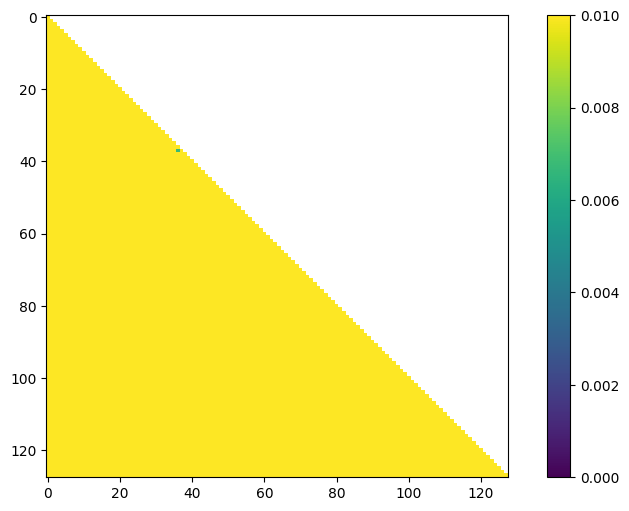

In [ ]:
fig = plot_numerical_diffs_single(matLogD_pt, matD_cu_half)

In [ ]:
(s_pt_half - matD_cu_half)[:, : , :10, :10]

tensor([[[[  8.9297,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000],
          [ 12.2578,   5.8711,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000],
          [ -8.4531,   6.9727,   6.3398,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000],
          [ -2.7695,  -1.8555,   6.5391, -17.5312,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000],
          [ -4.5703,  -8.4219,  -5.7344,   9.8594,  10.2266,  -1.0000,  -1.0000,  -1.0000,  -1.0000,  -1.0000],
          [ -3.1602,  16.6250,   7.1250, -11.1875,  -6.4180,  -5.2812,  -1.0000,  -1.0000,  -1.0000,  -1.0000],
          [  1.7363,   1.5859,  -2.9141, -11.7344,  -1.1104,  -1.8018,  -2.9922,  -1.0000,  -1.0000,  -1.0000],
          [ 22.3594, -10.7891,   3.2969, -17.5625,  -4.8125,  -9.0938,   1.2969,  -0.3926,  -1.0000,  -1.0000],
          [  0.1357, -13.4688,   7.1328,  -0.7695,   4.8672, -11.6719,  -0.5068,   3.8320, -17.7500,  -1

In [ ]:
(s_pt_half - matD_cu_half).abs().max()

tensor(44.9688, device='cuda:0', dtype=torch.float16)

In [ ]:
vs_half[:, :, :3, 32:]

tensor([[[[ 8.4326e-01,  2.5024e-01,  1.9668e+00, -7.2607e-01, -1.2266e+00,  1.9922e-01, -1.4668e+00, -6.7188e-01, -1.1328e+00,  1.1963e+00, -2.1912e-02, -2.8015e-02, -1.1530e-01,  1.5240e-03,
            7.8857e-01,  2.9565e-01,  1.1113e+00,  9.4580e-01, -7.9980e-01,  7.6221e-01,  1.0244e+00, -1.7090e+00, -3.4009e-01, -3.1274e-01,  1.3672e+00, -7.6123e-01, -1.8396e-01, -7.4707e-01,
            6.4697e-02,  1.2637e+00,  4.2139e-01,  2.8687e-01,  2.6538e-01,  3.9307e-02,  6.1377e-01,  1.6553e+00,  1.6846e+00, -4.0112e-01, -1.2900e+00, -3.8672e-01,  2.7295e-01,  3.5864e-01,
            1.6729e+00, -2.2949e-01,  2.2217e-01,  4.6655e-01, -5.3223e-01, -7.4463e-01, -1.1768e+00, -1.0029e+00, -1.7520e+00, -8.1201e-01, -1.5161e-01,  7.7979e-01,  6.8604e-01, -1.5332e-01,
           -9.6558e-02,  5.5078e-01,  7.2314e-01, -1.8262e+00, -1.0332e+00, -1.0590e-01,  5.8740e-01, -9.9414e-01],
          [ 8.2031e-01,  2.0879e+00,  4.3188e-01,  4.7180e-02,  1.0889e+00,  2.4524e-01,  1.7053e-01, -1.2090e+0

In [ ]:
matD_cu_half.shape

torch.Size([1, 1, 128, 128])

In [ ]:
matD_cu_half[:, :, :10, :10]

tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]]], device='cuda:0', dtype=torch.float16)

In [ ]:
hs_cu_half[:, :, :3, 32:]

tensor([[[[ 8.3750e+00,  2.4844e+00,  1.9531e+01, -7.2109e+00, -1.2180e+01,  1.9785e+00, -1.4562e+01, -6.6719e+00, -1.1250e+01,  1.1875e+01, -2.1753e-01, -2.7808e-01, -1.1445e+00,  1.5129e-02,
            7.8320e+00,  2.9355e+00,  1.1031e+01,  9.3906e+00, -7.9414e+00,  7.5703e+00,  1.0172e+01, -1.6969e+01, -3.3770e+00, -3.1055e+00,  1.3578e+01, -7.5586e+00, -1.8271e+00, -7.4180e+00,
            6.4258e-01,  1.2547e+01,  4.1836e+00,  2.8477e+00,  2.6348e+00,  3.9038e-01,  6.0938e+00,  1.6438e+01,  1.6734e+01, -3.9824e+00, -1.2812e+01, -3.8398e+00,  2.7109e+00,  3.5605e+00,
            1.6609e+01, -2.2793e+00,  2.2070e+00,  4.6328e+00, -5.2852e+00, -7.3945e+00, -1.1688e+01, -9.9609e+00, -1.7391e+01, -8.0625e+00, -1.5059e+00,  7.7422e+00,  6.8125e+00, -1.5225e+00,
           -9.5898e-01,  5.4688e+00,  7.1797e+00, -1.8141e+01, -1.0258e+01, -1.0518e+00,  5.8320e+00, -9.8750e+00],
          [ 1.6328e+01,  1.6438e+01,  2.8781e+01, -9.3281e+00, -9.4219e+00,  4.1797e+00, -1.8375e+01, -1.6500e+0

In [ ]:
(vs_half-hs_cu_half)[:, :, :3, 32:]

tensor([[[[-7.5312e+00, -2.2344e+00, -1.7562e+01,  6.4844e+00,  1.0953e+01, -1.7793e+00,  1.3094e+01,  6.0000e+00,  1.0117e+01, -1.0680e+01,  1.9556e-01,  2.5000e-01,  1.0293e+00, -1.3603e-02,
           -7.0430e+00, -2.6406e+00, -9.9219e+00, -8.4453e+00,  7.1406e+00, -6.8086e+00, -9.1484e+00,  1.5258e+01,  3.0371e+00,  2.7930e+00, -1.2211e+01,  6.7969e+00,  1.6436e+00,  6.6719e+00,
           -5.7812e-01, -1.1281e+01, -3.7617e+00, -2.5605e+00, -2.3691e+00, -3.5107e-01, -5.4805e+00, -1.4781e+01, -1.5047e+01,  3.5820e+00,  1.1523e+01,  3.4531e+00, -2.4375e+00, -3.2012e+00,
           -1.4938e+01,  2.0508e+00, -1.9844e+00, -4.1680e+00,  4.7539e+00,  6.6484e+00,  1.0508e+01,  8.9609e+00,  1.5641e+01,  7.2500e+00,  1.3545e+00, -6.9609e+00, -6.1250e+00,  1.3691e+00,
            8.6230e-01, -4.9180e+00, -6.4570e+00,  1.6312e+01,  9.2266e+00,  9.4580e-01, -5.2461e+00,  8.8828e+00],
          [-1.5508e+01, -1.4352e+01, -2.8344e+01,  9.3750e+00,  1.0508e+01, -3.9336e+00,  1.8547e+01,  1.5289e+0

In [ ]:
# cuda kernel bfloat16
hs_cu_bf16, n_cu_bf16, m_cu_bf16, matD_cu_bf16 = vlstm_fw_cuda(mat_Q=qs_bf16, mat_K=ks_bf16, mat_V=vs_bf16, vec_igp=igs_bf16, vec_fgp=fgs_bf16)

before kernel dispatch - bfloat16!
B: 1, NH: 1, S: 128, DH: 96
NUM_WARPS:4, GMEM_LOAD_BLOCK_COLS_X:4, GMEM_LOAD_BLOCK_ROWS_Y:32
blocksxy: 1-2, threadsxy: 128-1, QtileDim: 64, KVtileDim: 64, shared_mem in bytes: 94464
In FW-Kernel: gdim.x: 1, gdim.y: 2, gdim.z: 1, bdim.x: 128, bdim.y: 1
In FW-Kernel: QtileDim: 64, KVtileDim: 64


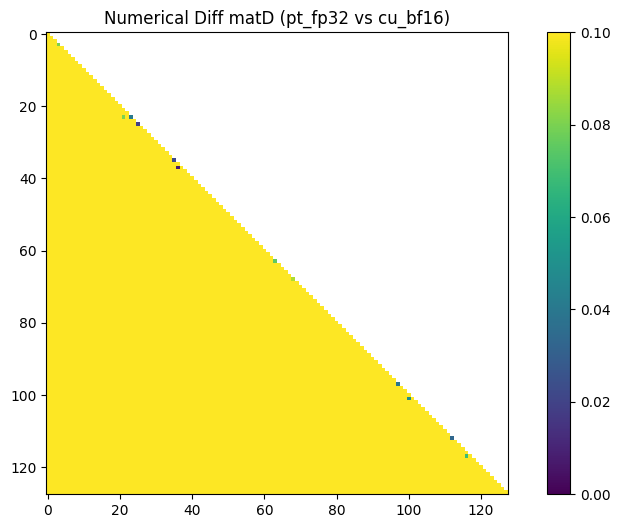

In [ ]:
fig = plot_numerical_diffs_single(matLogD_pt, matD_cu_bf16, title="Numerical Diff matD (pt_fp32 vs cu_bf16)", vmax=10e-2)

In [ ]:
matD_cu_bf16[:, :, :17, :16]

tensor([[[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
          [1

In [ ]:
# (qs_bf16 @ ks_bf16)[:, :, :17, :16]

In [ ]:
hs_cu_half.shape, qs_half.shape

(torch.Size([1, 1, 128, 96]), torch.Size([1, 1, 128, 96]))

In [ ]:
hs_cu_half, qs

(tensor([[[[-5.7695e+00, -1.0141e+01,  8.2734e+00,  3.2168e+00,  4.7305e+00,  7.4023e+00, -5.7852e+00,  1.8375e+01,  2.0254e+00,  2.4004e+00,  4.8555e+00, -8.7344e+00,  5.9961e+00, -5.6914e+00,
            -1.2109e+01, -1.8391e+01,  8.4922e+00,  2.4316e+00, -1.4639e+00,  1.4352e+01, -8.4688e+00,  9.2891e+00, -9.8594e+00, -6.8125e+00, -6.4570e+00,  5.6055e+00,  6.0859e+00,  1.9766e+01,
            -6.5234e-01, -2.1234e+01, -1.3213e+00, -6.8789e+00,  8.3750e+00,  2.4844e+00,  1.9531e+01, -7.2109e+00, -1.2180e+01,  1.9785e+00, -1.4562e+01, -6.6719e+00, -1.1250e+01,  1.1875e+01,
            -2.1753e-01, -2.7808e-01, -1.1445e+00,  1.5129e-02,  7.8320e+00,  2.9355e+00,  1.1031e+01,  9.3906e+00, -7.9414e+00,  7.5703e+00,  1.0172e+01, -1.6969e+01, -3.3770e+00, -3.1055e+00,
             1.3578e+01, -7.5586e+00, -1.8271e+00, -7.4180e+00,  6.4258e-01,  1.2547e+01,  4.1836e+00,  2.8477e+00,  2.6348e+00,  3.9038e-01,  6.0938e+00,  1.6438e+01,  1.6734e+01, -3.9824e+00,
            -1.2812e+01, -3.83

In [ ]:
FW_RTOL = 1e-10
FW_ATOL = 1e-4
BW_RTOL = FW_ATOL
BW_ATOL = FW_ATOL
print(f"Match against pt float32:")
print(f"====== Full ======")
print(f"fw hs match: {torch.allclose(hs_cu, hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu, n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu, m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu - matLogD_pt).tril(), torch.zeros_like((matD_cu)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu - matLogD_pt).tril())}")

print(f"====== Half ======")
print(f"fw hs match: {torch.allclose(hs_cu_half.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_half - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_half.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_half - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_half.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_half - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_half.float() - matLogD_pt).tril(), torch.zeros_like((matLogD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_half - matLogD_pt).tril())}")

print(f"====== bfloat16 ======")
print(f"fw hs match: {torch.allclose(hs_cu_bf16.float(), hs_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(hs_cu_bf16 - hs_pt))}")
print(f"fw n match: {torch.allclose(n_cu_bf16.float(), n_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(n_cu_bf16 - n_pt))}")
print(f"fw m match: {torch.allclose(m_cu_bf16.float(), m_pt, rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max(torch.abs(m_cu_bf16 - m_pt))}")
print(f"fw D match: {torch.allclose((matD_cu_bf16.float() - matLogD_pt).tril(), torch.zeros_like((matLogD_pt)), rtol=FW_RTOL, atol=FW_ATOL)}, max diff: {torch.max((matD_cu_bf16 - matLogD_pt).tril())}")


Match against pt float32:
====== Full ======
fw hs match: True, max diff: 0.0
fw n match: True, max diff: 0.0
fw m match: True, max diff: 0.0
fw D match: False, max diff: 105.7960205078125
====== Half ======
fw hs match: False, max diff: 94.3488998413086
fw n match: False, max diff: 29.268224716186523
fw m match: False, max diff: 0.9149842262268066
fw D match: False, max diff: 106.7960205078125
====== bfloat16 ======
fw hs match: False, max diff: 94.2238998413086
fw n match: False, max diff: 29.174474716186523
fw m match: False, max diff: 0.9147400856018066
fw D match: False, max diff: 106.7960205078125


In [ ]:
16 / 4

4.0

In [ ]:
13 % 4, 14 % 4

(1, 2)

In [ ]:
# ====== Full -> bfloat16 ======
# fw hs match: False, max diff: 0.15340876579284668
# fw n match: False, max diff: 0.09692215919494629
# fw m match: False, max diff: 0.05207604169845581
# fw D match: False, max diff: 0.15224838256835938
# ---------------------------------
# bw dQs match: False, max diff: 0.13966524600982666
# bw dKs match: False, max diff: 0.13031554222106934
# bw dVs match: False, max diff: 0.09818196296691895
# bw dIgs match: False, max diff: 0.12595558166503906
# bw dFgs match: False, max diff: 0.08353292942047119

### visualize diffs

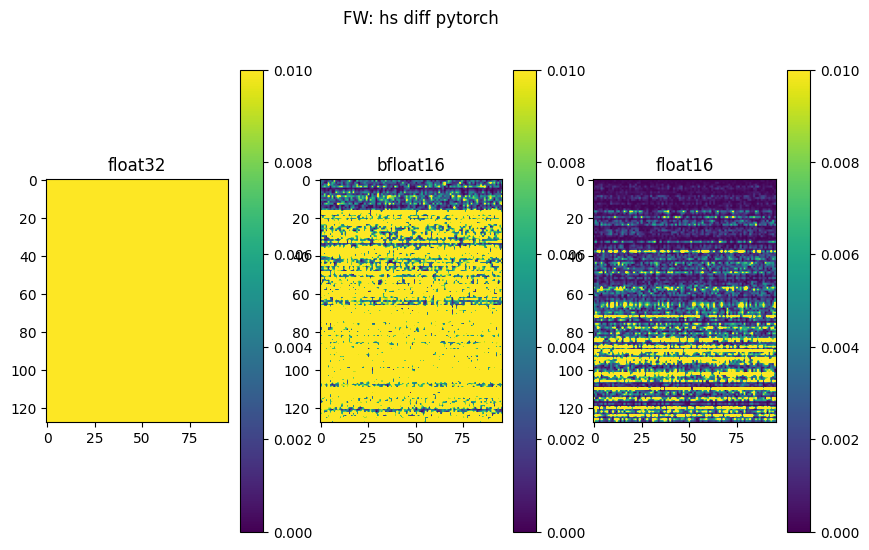

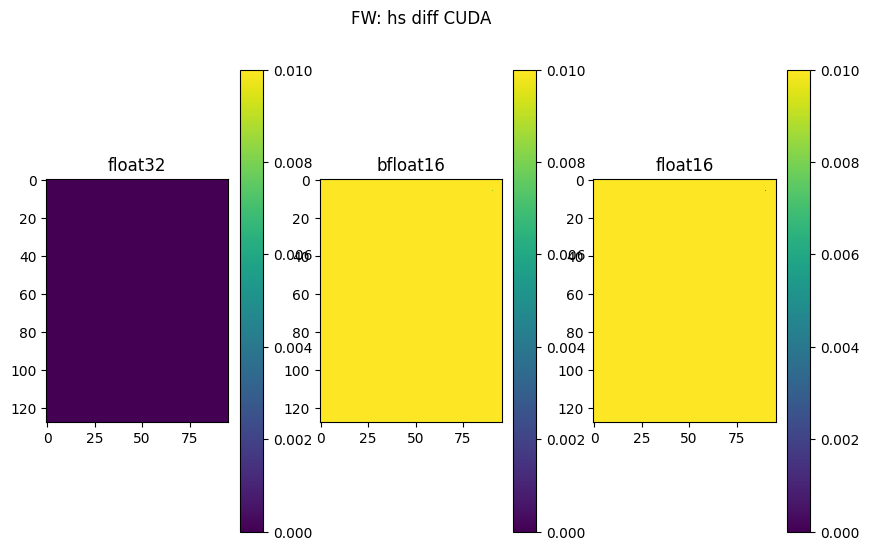

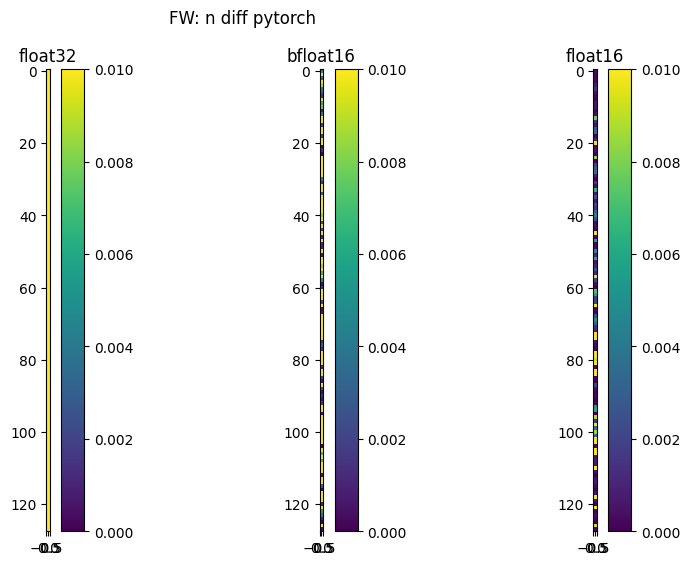

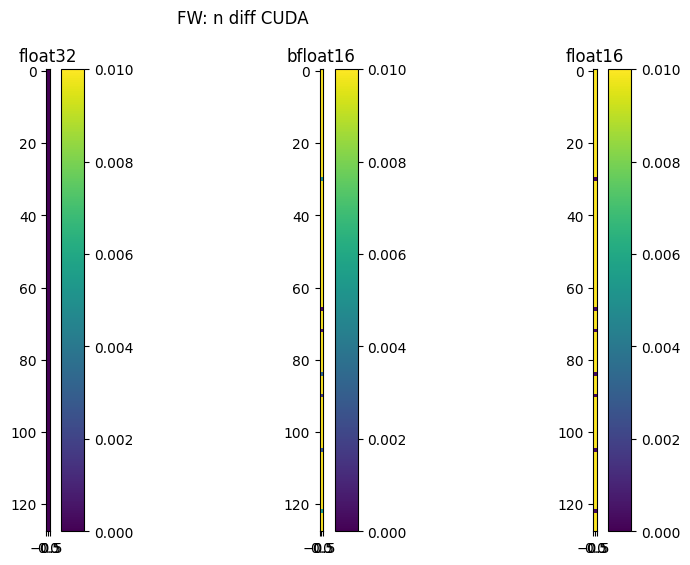

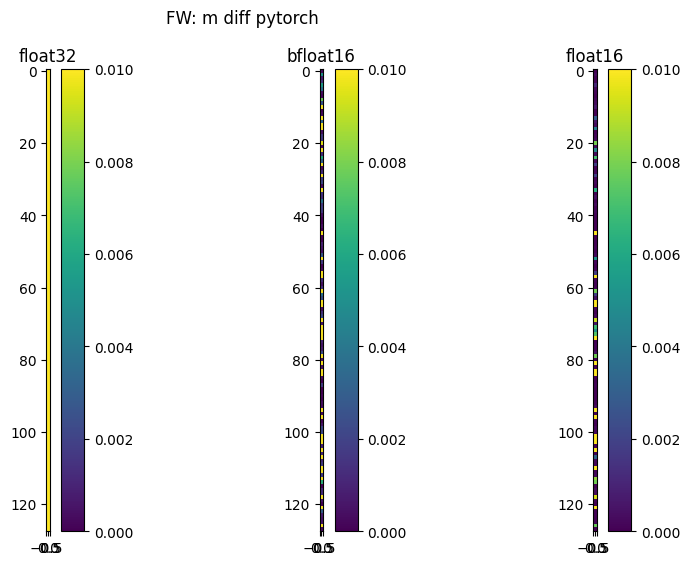

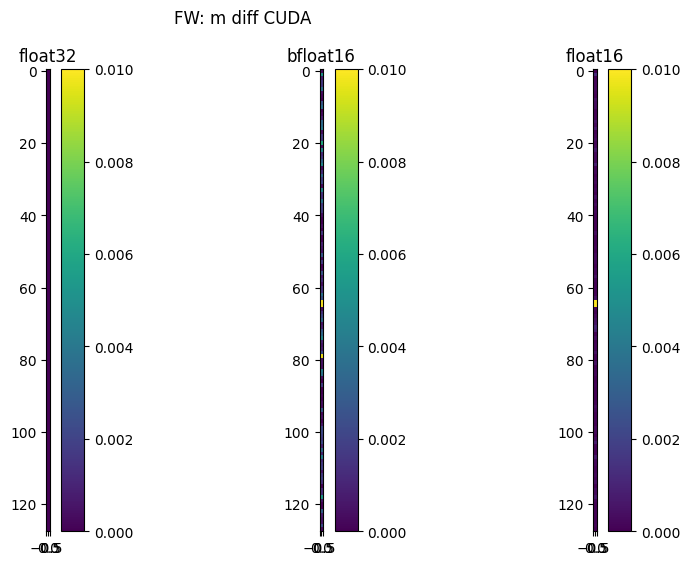

In [ ]:
## fw diffs
# hs
fig = plot_numerical_diffs(hs_pt, 10*torch.ones_like(hs_pt), hs_pt_bf16, hs_pt_half, title="FW: hs diff pytorch")
fig = plot_numerical_diffs(hs_pt, hs_cu, hs_cu_bf16, hs_cu_half, title="FW: hs diff CUDA")
# n 
fig = plot_numerical_diffs(n_pt, 10*torch.ones_like(n_pt), n_pt_bf16, n_pt_half, title="FW: n diff pytorch")
fig = plot_numerical_diffs(n_pt, n_cu, n_cu_bf16, n_cu_half, title="FW: n diff CUDA")
# m
fig = plot_numerical_diffs(m_pt, 10*torch.ones_like(m_pt), m_pt_bf16, m_pt_half, title="FW: m diff pytorch")
fig = plot_numerical_diffs(m_pt, m_cu, m_cu_bf16, m_cu_half, title="FW: m diff CUDA")